In [19]:
from __future__ import print_function
from keras.callbacks import LambdaCallback, EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras.models import load_model
from keras.models import Model
import numpy as np
import random
import sys
import io
import tensorflow as tf
import re
from keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt

#remove word Chapter
fin = open("/Users/neilwatt/Documents/BIs/PrWeb/2018Posts/August/TextGeneration/PrideAndPrejudice/Original.txt", encoding='utf-8')
fout = open("Clean.txt", "w+", encoding='utf-8')
delete_list = ['Chapter']
for line in fin:
    for word in delete_list:
        line = line.replace(word, "")
    fout.write(line)
fin.close()
fout.close()



In [2]:
#reading in copy of text with "Chapter" removed
Clean = '/Users/neilwatt/Documents/BIs/PrWeb/2018Posts/August/TextGeneration/PrideAndPrejudice/Clean.txt' # first command line arg
with io.open(Clean, encoding='utf-8') as f:
     Corpus = f.read().lower().replace('\n', ' \n ')

#remove numbers from text
text=re.sub(r"\b\d+\b", "", Corpus)

#review first 100 characters
text[:100]

' \n  \n  \n   \n  \n  \n it is a truth universally acknowledged, that a single man in possession \n of a go'

In [3]:


# runing this on a GPU as very computationally expensive
config = tf.ConfigProto()
#only allocate as much GPU memory based on runtime allocations, initially little but allows memory to be extended
config.gpu_options.allow_growth = True


chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters for calibrating model against
#here max length (maxlen) is pretty arbitrary, in future posts going to play around with this
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1



total chars: 52
nb sequences: 243191
Vectorization...


In [39]:
# build the model: a single LSTM
print('Build model...')
model = Sequential()
#the input shape is the max len of characters (set above)
#lens(chars) is simply the number of characters, in theory should consider controlling this

#the keras team use 128 units for a similar problem but this sis something we can optimise later
#note I added "return_sequences=True" to the first LSTM layer
model.add(LSTM(128,  return_sequences=True,input_shape=(maxlen, len(chars))))
model.add(Dropout(0.2))
model.add(LSTM(50, input_shape=(maxlen, len(chars))))
#the dense layer uses the number of characters as units
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

#lr=learning rate, i definately want to come back and optimise this later
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)


Build model...


In [34]:
#temperature is a hyperparameter to control randomess of predictions by scaling logts before softmax
#temperature scales the logits before applying softmax

def sample(preds, temperature=0.5):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)




In [35]:
def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
            
# define the checkpoint so I can load model in future
filepath = "weightssecondlayer.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='loss', 
                             verbose=1, 
                             save_best_only=True, 
                 
                             mode='min')
earlystop = EarlyStopping(monitor='val_loss', patience=2,
                              verbose=2)

#

# fit model using the gpu
#batch size is a particularly important hyperparamter which I intend to play around within future posts
with tf.device('/gpu:0'):

    history=model.fit(x, y,validation_split=0.1,batch_size=200,epochs=60,verbose=2,callbacks=[print_callback, checkpoint,earlystop])


Train on 218871 samples, validate on 24320 samples
Epoch 1/60
 - 324s - loss: 2.0141 - val_loss: 1.8310

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "ttributing any part of mr. bingley's con"
ttributing any part of mr. bingley's condeered the marrient of his intered the compering of his before the 
 married to prosers to be 
 condent to so condering of his contering the rester her the 
 marrient to the 
 collins of his had his one the 
 
 there all the 
 comparing of the 
 so the repliess to see his 
 seeure the 
 being to her comparing of his comparing of his be 
 
 be the 
 darcy of his being of his had the seesed the marr
----- diversity: 0.5
----- Generating with seed: "ttributing any part of mr. bingley's con"
ttributing any part of mr. bingley's condaned a they reverrings. than only farter mistry 
 been to the his of his reess comperined and before agass the all mearing they deer 
 sand of set meril incearil ther every 
 as undersed been 

In [22]:

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               92672     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 52)                6708      
_________________________________________________________________
activation_2 (Activation)    (None, 52)                0         
Total params: 99,380
Trainable params: 99,380
Non-trainable params: 0
_________________________________________________________________


In [23]:
print(history.history.keys())

dict_keys(['val_loss', 'loss'])


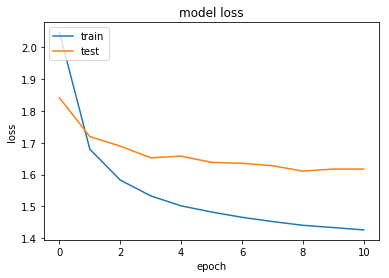

In [37]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
#let's now generate some text using the model
def generate_output():
    generated = ''
    usr_input = input("Input some sample text and the model will attempt to complete it in Jane Austen style. Your input is: ")
    sentence = ('{0:0>' + str(maxlen) + '}').format(usr_input).lower()
    generated += usr_input 

    sys.stdout.write("\n\nHere is the end of your story: \n\n") 
    sys.stdout.write(usr_input)
    for i in range(400):

        
        x = np.zeros((1, maxlen, len(chars)))

        for t, char in enumerate(sentence):
            if char != '0':
                x[0, t, char_indices[char]] = 1.

        
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, temperature = 1.0)
        next_char = indices_char[next_index]

        generated += next_char
        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()

        if next_char == '\n':
            continue

In [15]:


generate_output()

Input some sample text and the model will attempt to complete it in Jane Austen style. Your input is: I went to the park with Darcy.


Here is the end of your story: 

I went to the park with Darcy. that your noting as aftrame respectment not seetly of a granspacts. to consider the at any returning, by one liat 
 at the dunting from conceally ment grabite as ill a servant able to 
 heltfords, and took of engagned. she would not pertagth his near bail, she kind, to particular in derectured she did not it had doubted in spoking mr. bennet sexter on to his 
 difnered before to then, in use seem